# Example 2: MPD-TMC polyamides
Linear polymer subset of crosslinked polyamide structure ensemble 

In [1]:
from rdkit.Chem.Draw import MolsToGridImage
from polymerist.rdutils.rdkdraw import set_rdkdraw_size, disable_substruct_highlights, enable_kekulized_drawing


# Molecule drawing settings
MOL_IMG_WIDTH  : int = 400
MOL_IMG_HEIGHT : int = 300
MOL_IMG_SIZE = (MOL_IMG_WIDTH, MOL_IMG_HEIGHT)

enable_kekulized_drawing()
disable_substruct_highlights()
set_rdkdraw_size(MOL_IMG_WIDTH, MOL_IMG_WIDTH / MOL_IMG_HEIGHT)

## Define chemically-complete monomer "feedstocks"

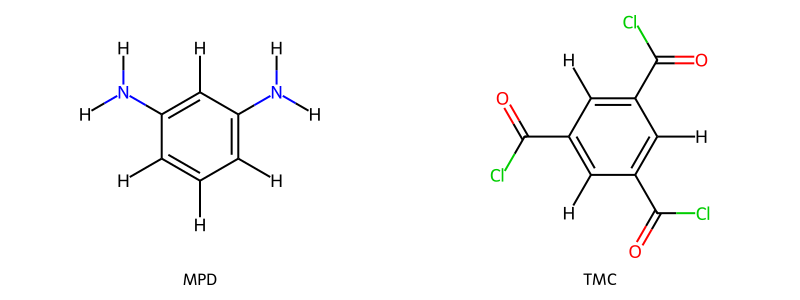

In [2]:
from rdkit.Chem.rdchem import Mol
from rdkit.Chem.rdmolops import SANITIZE_ALL, AROMATICITY_MDL
from polymerist.rdutils.sanitization import explicit_mol_from_SMILES, Smiles


monomer_smiles : dict[str, Smiles] = {
    'MPD' : 'c1ccc(N)cc1N',                        # m-phenylene diamine
    'TMC' : 'c1c(C(=O)Cl)cc(C(=O)Cl)cc1(C(=O)Cl)', # trimesoyl chloride
}
monomers : dict[str, Mol] = {
    name : explicit_mol_from_SMILES(smiles, sanitize_ops=SANITIZE_ALL, aromaticity_model=AROMATICITY_MDL)
    for name, smiles in monomer_smiles.items()
}

MolsToGridImage(monomers.values(), molsPerRow=len(monomers), subImgSize=MOL_IMG_SIZE, legends=list(monomers.keys()))

## Define polymerization reaction template based on active functional groups

### Assemble reaction from target functional groups (in this case an amide and an acyl chloride)

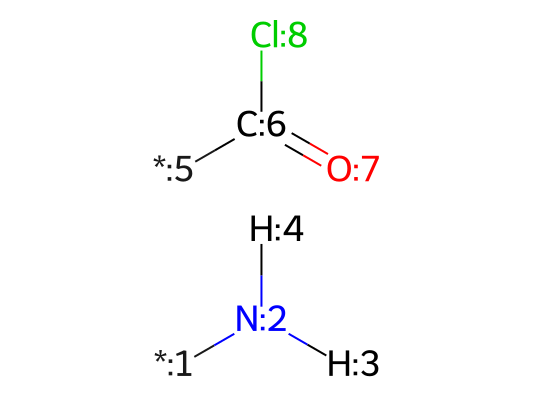

In [3]:
from rdkit.Chem.rdmolfiles import MolFromSmarts, MolToSmiles
from polymerist.rdutils.reactions import ReactionAssembler


assem = ReactionAssembler(
    reactive_groups=[
        MolFromSmarts('*-N(-[H])(-[H])'), # amine group
        MolFromSmarts('*-C(=O)-Cl'),      # acyl chloride group
    ],
    byproducts=[MolFromSmarts('[H]-[Cl]')], # eject and unmap HCl byproduct
    rxn_name='amide-acyl chloride condensation',
)
display(assem.reactants)

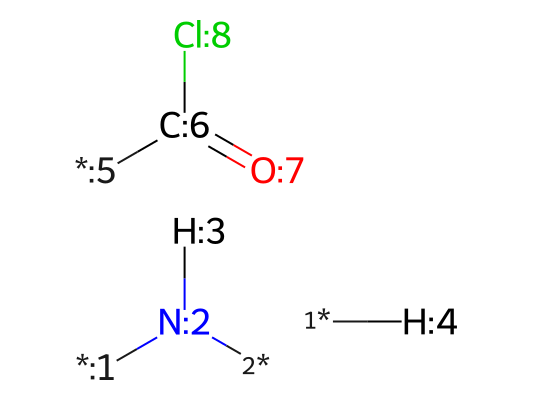

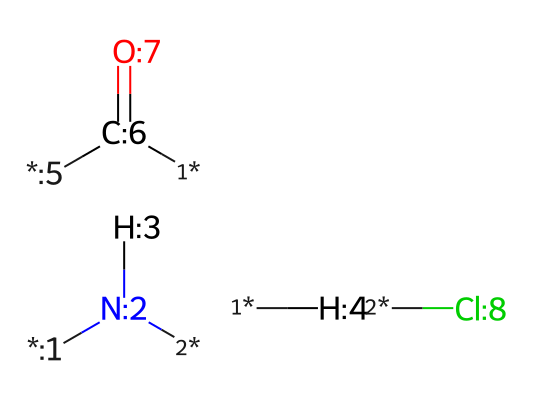

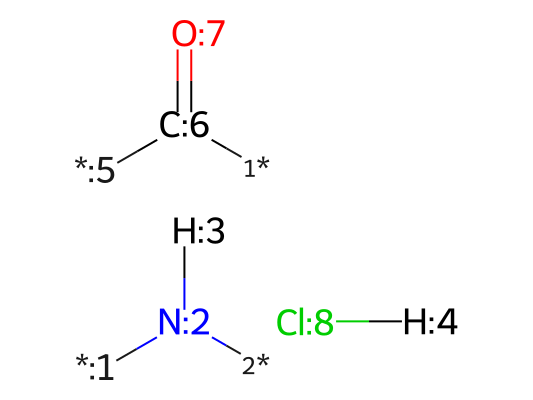

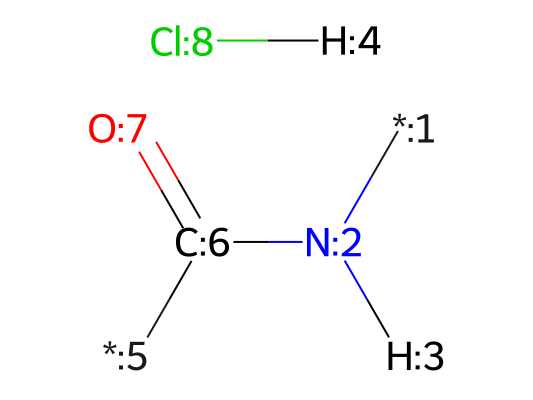

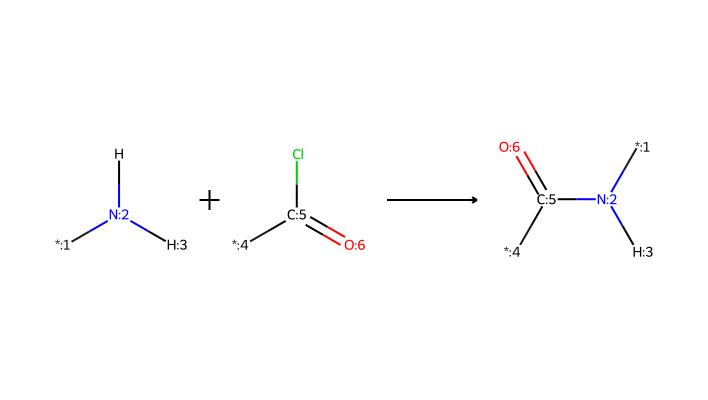

In [4]:
assem.bond_derangement = {
    4 : (2, 8), # H:4, which was connected to C:2, should reconnect to Cl:8
    6 : (8, 2), # C:6, which was connected to Cl:8, should reconnect to C:2
} # note that this forms a closed bond cycle, since atoms 2 and 8 each gain and lose 1 bond, respectively, amounting to no net valence change

rxn = assem.assemble_rxn(show_steps=True)
display(rxn)

### Export reaction for re-use

In [7]:
from pathlib import Path

rxn_smarts = rxn.to_smarts()
rxn_dir = Path(f'rxn_demo_files/rxns')
rxn_dir.mkdir(parents=True, exist_ok=True)
rxn.to_rxnfile(rxn_dir / f'{rxn.rxnname}.rxn')

## Enumerate all possible repeat unit fragments from monomers and reaction template

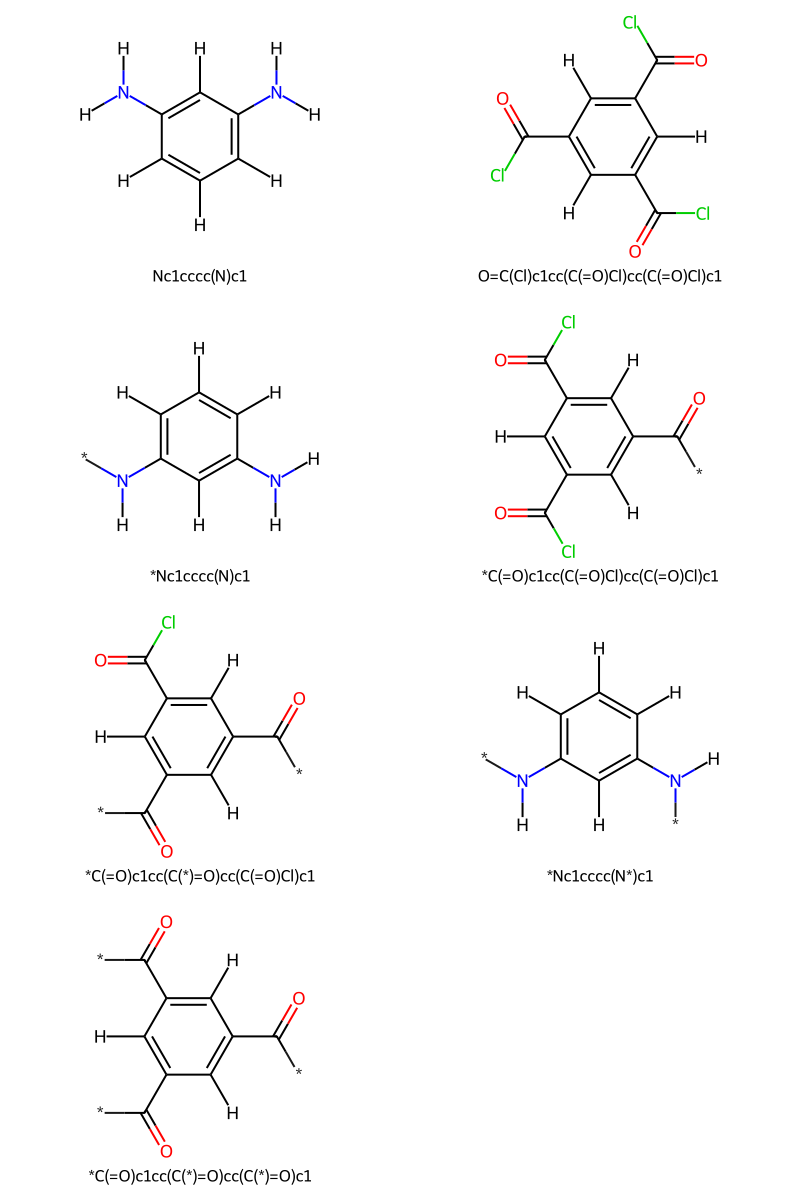

In [8]:
from polymerist.rdutils.reactions import AnnotatedReaction
from polymerist.rdutils.reactions import PolymerizationReactor, CutMinimumCostBondsStrategy


reactor = PolymerizationReactor(
    rxn_schema=AnnotatedReaction.from_smarts(rxn_smarts),
    fragment_strategy=CutMinimumCostBondsStrategy()
)
fragments = reactor.propagate_pooled(
    monomers.values(),
    sanitize_ops=SANITIZE_ALL,
    aromaticity_model=AROMATICITY_MDL,
    clear_dummy_labels=True,
)
MolsToGridImage(fragments.values(), molsPerRow=2, subImgSize=MOL_IMG_SIZE, legends=list(fragments.keys()))

### Generate monomer specification-compliant SMARTS with informative names for each non-monomer fragment

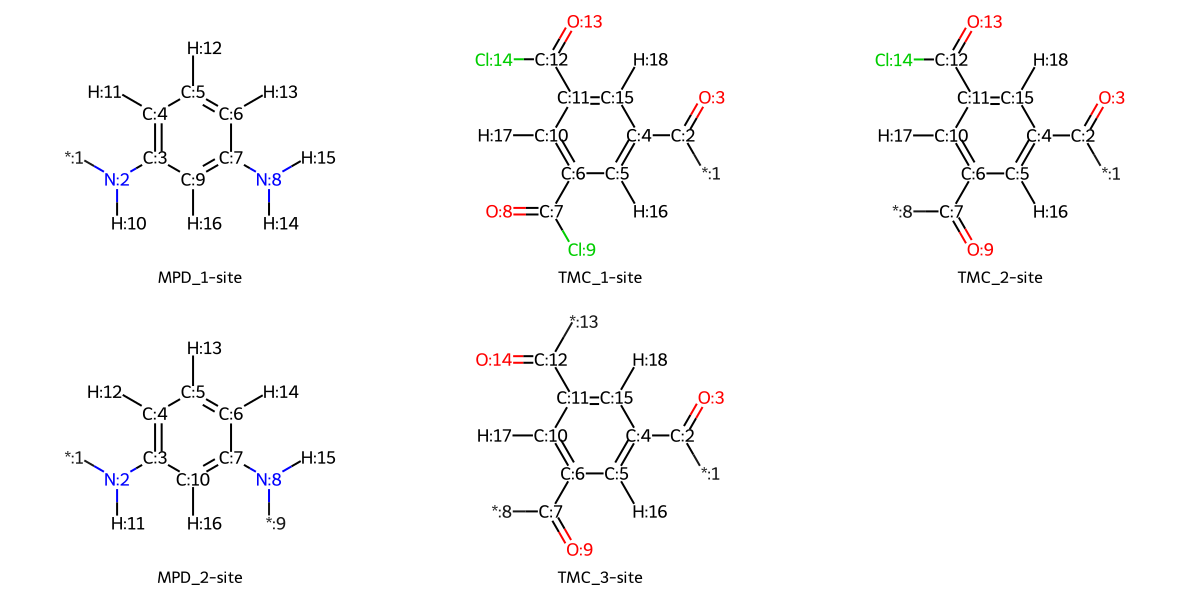

In [9]:
from polymerist.polymers.monomers import MonomerGroup
from polymerist.rdutils.bonding.portlib import get_num_ports


named_fragments : dict[str, Smiles] = {}
for canon_smiles, fragment_mol in fragments.items():
    functionality = get_num_ports(fragment_mol)
    if functionality == 0:
        continue # skip fragments with no ports, as these are not useful for polymerization
    
    query_mol = MolFromSmarts(canon_smiles) # important! need to makes SMARTS-based query mol to check for substructure - ports on returned SMILES-based mols are not treated correctly as wild-type atoms
    parent_mol_name = '-'.join(name for name, monomer in monomers.items() if monomer.HasSubstructMatch(query_mol))
    named_fragments[f'{parent_mol_name}_{functionality}-site'] = canon_smiles
    
monogrp = MonomerGroup(named_fragments)
MolsToGridImage([mol for _, mol in monogrp.iter_rdmols()], molsPerRow=3, subImgSize=MOL_IMG_SIZE, legends=list(monogrp.monomers.keys()))

## Use fragments to assemble a polymer

In [10]:
from polymerist.polymers.building import build_linear_polymer, mbmol_to_rdkit_pdb


# NOTE: unless you explicitly provide term group orientations, the builder will automatically choose the first two
# terminal groups as head and tail, respectively, in whatever order they appear, or the only terminal group twice if just one is provided
monogrp.term_orient = {
    'head' : 'MPD_1-site',
    'tail' : 'TMC_1-site',
}
chain = build_linear_polymer(
    monomers=monogrp,
    sequence='AB', # will alternate TMC and MPD 2-site monomers after the MPD head group (A and B correspond to the order these monomers appear in the monomer group)
    n_monomers=30,
    energy_minimize=False, # this will make PDB generation much faster but give less physical structures
)
chain.visualize()

[20:25:41] WARNING: not removing hydrogen atom with dummy atom neighbors


3Dmol.js failed to load for some reason. Please check your browser console for error messages.